# Отток клиентов


**Описание проекта:**
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 
Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.
Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.


**Описание данных**

Данные находятся в файле `/datasets/Churn.csv` (англ. «отток клиентов»).

**Признаки**
* *RowNumber* — индекс строки в данных
* *CustomerId* — уникальный идентификатор клиента
* *Surname* — фамилия
* *CreditScore* — кредитный рейтинг
* *Geography* — страна проживания
* *Gender* — пол
* *Age* — возраст
* *Tenure* — сколько лет человек является клиентом банка
* *Balance* — баланс на счёте
* *NumOfProducts* — количество продуктов банка, используемых клиентом
* *HasCrCard* — наличие кредитной карты
* *IsActiveMember* — активность клиента
* *EstimatedSalary* — предполагаемая зарплата

**Целевой признак**
* *Exited* — факт ухода клиента


**Этапы работы:**
* Загрузка и подготовка данных. 
* Исследование баланса классов, обучение модели без учёта дисбаланса. 
* Улучшение качества модели с учетом дисбаланса классов: обучение разных моделей и выбор лучшей.
* Финальное тестирование.


## Подготовка данных

Импортируем библиотеки и модули, которые потребуются для выполнения проекта

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

Загрузим и изучим данные

In [2]:
try:
    data = pd.read_csv('datasets/Churn.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')


data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Можно отметить следующее:**

1. В столбце `Tenure` есть пропуски. Их следует обработать.
2. В столбцах `RowNumber`, `CustomerId`, `Surname` указаны идентификационные данные, которые не являются признаками. При дальнейшем исследовании они не потребуются.
3. Столбцы `Geography` и `Gender` имеют тип `object`. Его следует перевести в числовой.

Обработаем данные.

### Обработка пропусков

Посчитаем долю пропусков в столбце `Tenure`.

In [4]:
data['Tenure'].isna().mean()

0.0909

Доля пропусков – 9.09%. Для того, чтобы решить, каким образом их лучше всего обработать, рассмотрим распределение значений в столбце `Tenure`.

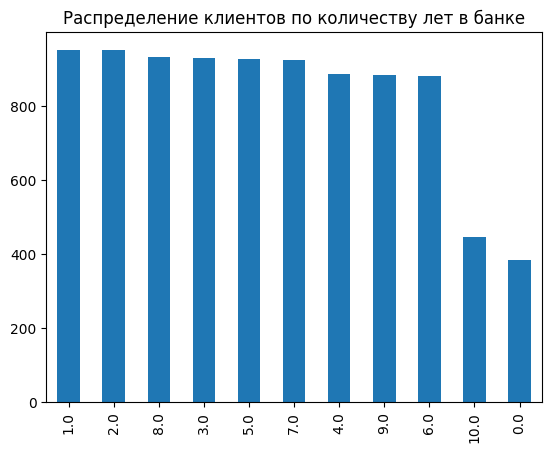

In [5]:
data['Tenure'].value_counts().plot(kind='bar', title='Распределение клиентов по количеству лет в банке');

Значения в в столбце `Tenure` соответствуют количеству лет, в течение которого человек является клиентом банка. Значения находятся в диапазоне от 0 до 10, при этом наименьшие доли составляют значения 0 и 10 (то есть самое большое и самое маленькое). Такое распределение можно объяснить. Будем считать, что 0 означает, что человек стал клиентом банка меньше года назад, и, поскольку эти данные включают период меньше года, логично, что количество клиентов, "пришедших" в банк за это время, будет меньше, чем за целый год. То же самое можно предположить и о периоде в 10 лет: поскольку это максимальное значение в датасете, можно предположить, что это год основания банка, и, вероятно, данные представлены за период меньше года.

Возможные варианты обработки пропусков:
* заполнение медианным значением
* заполнение нулевым значением (если предположить, что данные не успели внести)
* удаление соответствующих строк датасета

Заполнение нулем или медианой приведет к тому, что одно значение (0 или 5) будет составлять неправдоподобно большую долю, поэтому для сохранения имеющегося распределения удалим строки с пропущенными значениями.

In [6]:
data = data.dropna(subset=['Tenure']).reset_index(drop=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        9091 non-null   int64  
 1   CustomerId       9091 non-null   int64  
 2   Surname          9091 non-null   object 
 3   CreditScore      9091 non-null   int64  
 4   Geography        9091 non-null   object 
 5   Gender           9091 non-null   object 
 6   Age              9091 non-null   int64  
 7   Tenure           9091 non-null   float64
 8   Balance          9091 non-null   float64
 9   NumOfProducts    9091 non-null   int64  
 10  HasCrCard        9091 non-null   int64  
 11  IsActiveMember   9091 non-null   int64  
 12  EstimatedSalary  9091 non-null   float64
 13  Exited           9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 994.5+ KB


Пропуски устранены.

### Удалим столбцы с идентификационными данными, не являющимися признаками

In [8]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis='columns')

In [9]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Столбцы `RowNumber`, `CustomerId`, `Surname` удалены.

### Преобразование типов данных

Преобразуем признаки в столбцах `Geography` и `Gender` в численные при помощи техники прямого кодирования (англ. *One-Hot Encoding, OHE*). Чтобы избежать дамми-ловушки, используем аргумент `drop_first=True`

In [10]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [11]:
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [12]:
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        9091 non-null   int64  
 1   Age                9091 non-null   int64  
 2   Tenure             9091 non-null   float64
 3   Balance            9091 non-null   float64
 4   NumOfProducts      9091 non-null   int64  
 5   HasCrCard          9091 non-null   int64  
 6   IsActiveMember     9091 non-null   int64  
 7   EstimatedSalary    9091 non-null   float64
 8   Exited             9091 non-null   int64  
 9   Geography_Germany  9091 non-null   uint8  
 10  Geography_Spain    9091 non-null   uint8  
 11  Gender_Male        9091 non-null   uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 666.0 KB


Теперь все столбцы имеют числовой формат.

### Разделим данные на выборки и масштабируем признаки

1. Целевой признак – значение в столбце `'Exited'`. Cоздадим переменные для признаков (`features`) и целевого признака (`target`).

In [13]:
features = data_ohe.drop('Exited', axis=1)
target = data_ohe['Exited']

# выведем на экран размеры таблиц
print(features.shape)
print(target.shape)

(9091, 11)
(9091,)


2. Разобьем ,данные на три части: обучающую, валидационную и тестовую выборки в соотношении 3:1:1. Выполним разбивку в два шага: сначала разделим данные на обучающие и валидационные/тестовые в соотношении на 3:2, затем разделим валидационные/тестовые данные в на валидационную и тестовую выборки в соотношении 1:1.

In [14]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

# выведем на экран размеры таблиц, которые хранятся в переменных
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(5454, 11)
(5454,)
(1819, 11)
(1819,)
(1818, 11)
(1818,)


3. Масштабируем количественные признаки методом стандартизации данных

In [15]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Выводы по разделу 1


1. Данные загружены и изучены.
2. Устранены пропуски в столбце `Tenure`.
3. Удалены столбцы `RowNumber`, `CustomerId`, `Surname`, данные в которых не являются признаками
4. Признаки в столбцах `Geography` и `Gender` преобразованы в численные при помощи техники прямого кодирования (*OHE*).
5. Данные разделены на выборки, количественные признаки масштабированы.

Данные подготовлены, можно приступать к обучению.

## Исследование задачи

### Баланс классов

Проверим, как часто в целевом признаке встречается класс "1" или "0". Количество уникальных значений подсчитаем методом `value_counts()` и построим диаграмму методом `plot()`.

0    0.796062
1    0.203938
Name: Exited, dtype: float64


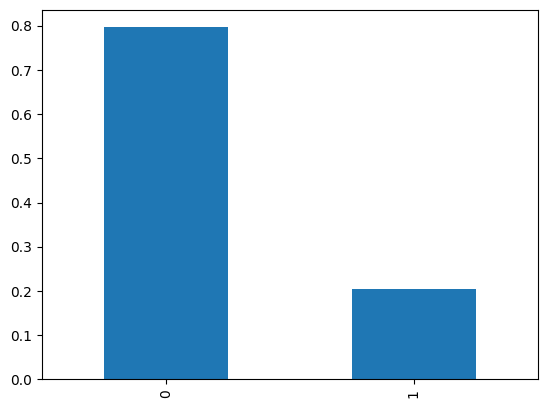

In [16]:
target_class_frequency = data_ohe['Exited'].value_counts(normalize=True)
print(target_class_frequency)
target_class_frequency.plot(kind='bar');

Наблюдается дисбаланс классов: класс "1" встречается в целевом признаке в 4 раза чаще, чем класс "0".

### Обучение моделей без учета дисбаланса классов

Перед нами задача класификации, поэтому обучим модели классификации: дерево решений (`DecisionTreeClassifier`), случайный лес (`RandomForestClassifier`) и логистическую регрессию (`LogisticRegression`).

Обучим модели и определим значение `accuracy` на валидационной выборке. На данном этапе значения гиперпараметров оставляем по умолчанию (значения гиперпараметров подобраны вручную).

#### Дерево решений

In [17]:
dt_model = DecisionTreeClassifier(random_state=12345)
dt_model.fit(features_train, target_train)
dt_predicted_valid = dt_model.predict(features_valid)
accuracy_score(target_valid, dt_predicted_valid)

0.799890049477735

#### Случайный лес

Обучим модель и определим значение `accuracy` на валидационной выборке (значения гиперпараметров подобраны вручную).

In [18]:
rf_model = RandomForestClassifier(random_state=12345)
rf_model.fit(features_train, target_train)
rf_predicted_valid = rf_model.predict(features_valid)
rf_model.score(features_valid, target_valid)

0.8680593732820231

#### Логистическая регрессия

In [19]:
lr_model = LogisticRegression(random_state=12345, solver='liblinear')
lr_model.fit(features_train, target_train)
lr_predicted_valid = lr_model.predict(features_valid)
lr_model.score(features_valid, target_valid)

0.8251786695986806

Лучшее значение `accuracy` (0.87) на валидационной выборке показывает модель случайного леса. Это много или мало? Сравним с результатами константной модели.

#### Константная модель

Сравним результаты для лучшей модели с со значением `accuracy` для константной модели, то есть модели, которая для любого объекта прогнозирует одинаковое значение целевого признака (`'Exited' = 0).

In [20]:
target_pred_constant = pd.Series(0, index=target_valid.index)
accuracy_score(target_valid, target_pred_constant)

0.8070368334249588

Значение `accuracy` моделей  случайного леса и логистической регрессии выше, чем показатель для константной модели, однако ненамного, что может вызвать сомнения в адекватности моделей. 

#### F1-мера и ROC-кривая

`F1-мера` оценивает качество прогноза положительного класса и представляет собой среднее гармоническое полноты (recall) и точности (precision).

Показательно, что значение F1-меры для константной модели равно 0.

In [21]:
f1_score(target_valid, target_pred_constant)

0.0

In [22]:
print('F1-мера дерева решений', f1_score(target_valid, dt_predicted_valid))
print('F1-мера случайного леса', f1_score(target_valid, rf_predicted_valid))
print('F1-мера логистической регрессии', f1_score(target_valid, lr_predicted_valid))

F1-мера дерева решений 0.4958448753462604
F1-мера случайного леса 0.5714285714285714
F1-мера логистической регрессии 0.3175965665236052


Дополнительно измерим AUC-ROC и сравним её значения с F1-мерой. Для этого напишем функцию, `auc_roc()` name c параметром `model` (модель, для которой строится кривая), которая возвращает график график ROC-кривой и значение AUC-ROC.

In [23]:
def auc_roc_curve_plus_score(model):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC-кривая для {model}")
    plt.show()
    
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print(f"AUC-ROC для {model}, {auc_roc}")
    return 

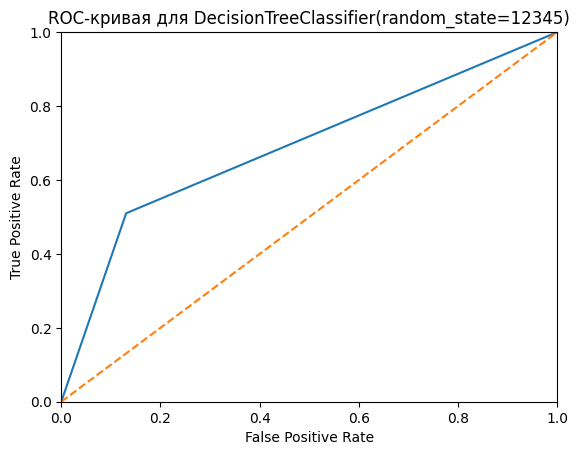

AUC-ROC для DecisionTreeClassifier(random_state=12345), 0.6895906596179077


In [24]:
auc_roc_curve_plus_score(dt_model)

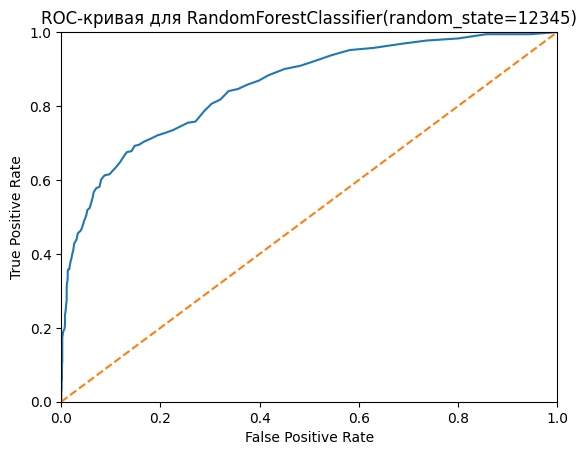

AUC-ROC для RandomForestClassifier(random_state=12345), 0.8516267262861269


In [25]:
auc_roc_curve_plus_score(rf_model)

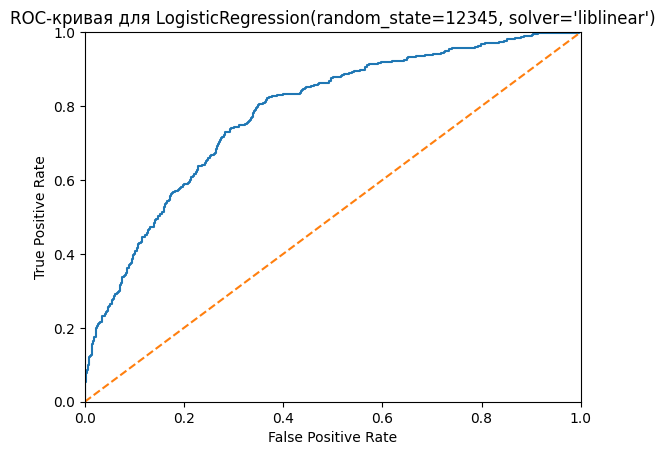

AUC-ROC для LogisticRegression(random_state=12345, solver='liblinear'), 0.780939239386106


In [26]:
auc_roc_curve_plus_score(lr_model)

Значение AUC-ROC также выше всего для модели случайного леса.

### Выводы по разделу 2

1. В целевом признаке наблюдается дисбаланс классов: класс "1" встречается в 4 раза чаще, чем класс "0".
2. Рассмотрены значения `accuracy` моделей дерева решений, случайного леса и логистической регрессии. Лучший показатель у модели случайного леса.
3. В результате дисбаланса классов константная модель также показывает относительно высокое значение `accuracy`.
4. Значение `F1-меры` у моделей без учета дисбаланса классов оказывается ниже требуемого порога 0.59.

## Борьба с дисбалансом

Применим три техники борьбы с дисбалансом классов: взвешивание классов, увеличение выборки (*upsampling*) и уменьшение выборки (*downsampling*) – и проследим, как изменяется значение `F1-меры` при их применении.

### Взвешивание классов

В алгоритмах рассматриваемых моделей (дерева решений, случайного леса и логистической регрессии) в библиотеке `sklearn` есть аргумент `class_weight`. Укажем `class_weight='balanced'` (англ. «сбалансированный»).

#### Дерево решений

In [27]:
dt_model_balanced = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
dt_model_balanced.fit(features_train, target_train)
dt_predicted_valid_balanced = dt_model_balanced.predict(features_valid)
print("F1:", f1_score(target_valid, dt_predicted_valid_balanced))

F1: 0.4720327421555253


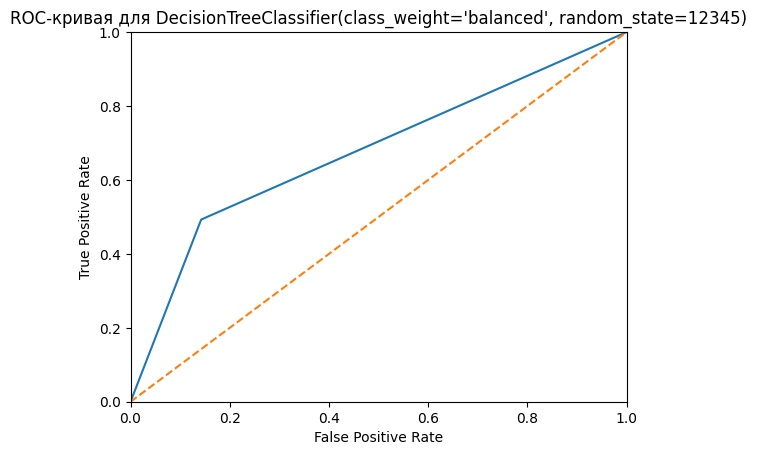

AUC-ROC для DecisionTreeClassifier(class_weight='balanced', random_state=12345), 0.6752534603352042


In [28]:
auc_roc_curve_plus_score(dt_model_balanced)

*Подбор гиперпараметров*

In [29]:
best_dt_model_balanced = None
best_f1_dt_balanced = 0
for criterion in ['entropy', 'gini']:
    for depth in range(1,15):
        model = DecisionTreeClassifier(random_state=12345, class_weight='balanced', max_depth=depth, 
                                        criterion=criterion)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1_dt_balanced:
            best_dt_model_balanced = model
            best_f1_dt_balanced = f1
            best_depth = depth
            best_criterion = criterion
            

print('F1 лучшей модели:', best_f1_dt_balanced)
print('max_depth:', best_depth)
print('criterion:', best_criterion)

F1 лучшей модели: 0.5653631284916201
max_depth: 5
criterion: gini


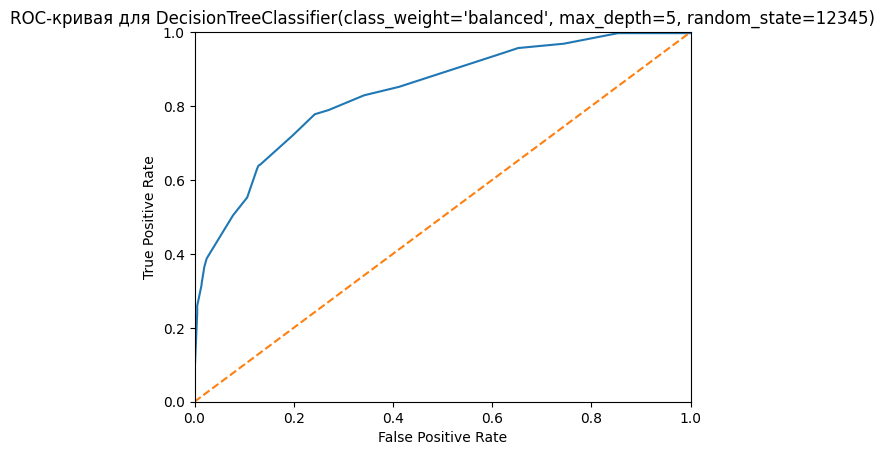

AUC-ROC для DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345), 0.8374962155616106


In [30]:
auc_roc_curve_plus_score(best_dt_model_balanced)

При изменении гиперпараметров значение AUC-ROC значительно возрастает, однако F1 не достигает требуемого порога 0.59.

#### Случайный лес

In [31]:
rf_model_balanced = RandomForestClassifier(random_state=12345, class_weight='balanced')
rf_model_balanced.fit(features_train, target_train)
rf_predicted_valid_balanced = rf_model_balanced.predict(features_valid)
print("F1:", f1_score(target_valid, rf_predicted_valid_balanced))

F1: 0.5683060109289617


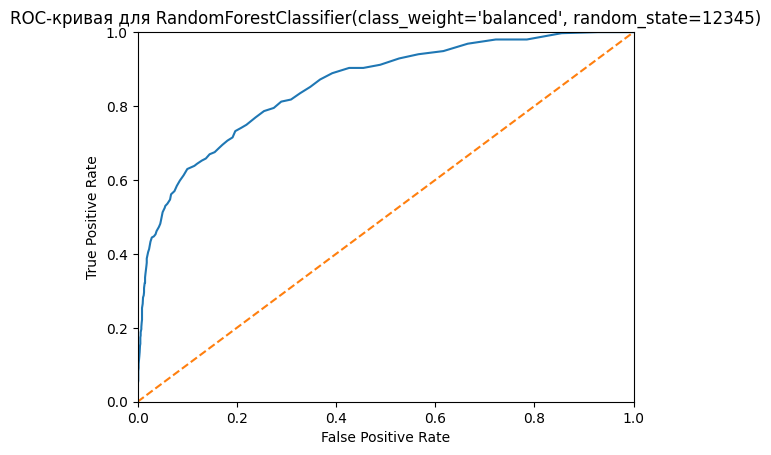

AUC-ROC для RandomForestClassifier(class_weight='balanced', random_state=12345), 0.8550307800988999


In [32]:
auc_roc_curve_plus_score(rf_model_balanced)

*Подбор гиперпараметров*

In [33]:
best_rf_model_balanced = None
best_f1_rf_balanced = 0
for est in range(1, 51): 
    for depth in range(1, 15):
        model = RandomForestClassifier(random_state=12345, class_weight='balanced',
                                       n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1_rf_balanced:
            best_rf_model_balanced = model
            best_f1_rf_balanced = f1
            best_est = est
            best_depth = depth
        
print("F1 лучшей модели на валидационной выборке:", best_f1_rf_balanced)
print("Число деревьев в наилучшей модели:", best_est)
print("max_depth наилучшей модели:", best_depth)

F1 лучшей модели на валидационной выборке: 0.6233062330623307
Число деревьев в наилучшей модели: 25
max_depth наилучшей модели: 9


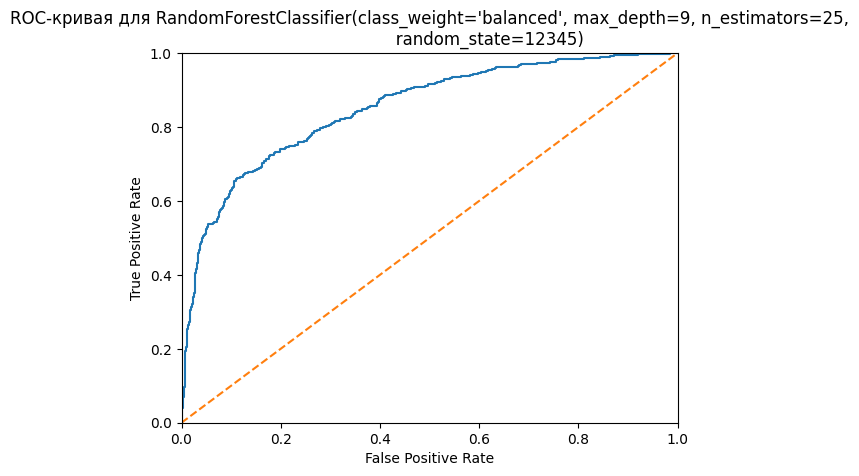

AUC-ROC для RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=25,
                       random_state=12345), 0.8503380764961147


In [34]:
auc_roc_curve_plus_score(best_rf_model_balanced)

При изменении гиперпараметров значение F1-меры оказывается выше требуемого порога 0.59, значение AUC-ROC меняется незначительно.

#### Логистическая регрессия

In [35]:
lr_model_balanced = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
lr_model_balanced.fit(features_train, target_train)
lr_predicted_valid_balanced = lr_model_balanced.predict(features_valid)
print("F1:", f1_score(target_valid, lr_predicted_valid_balanced))

F1: 0.5025432349949135


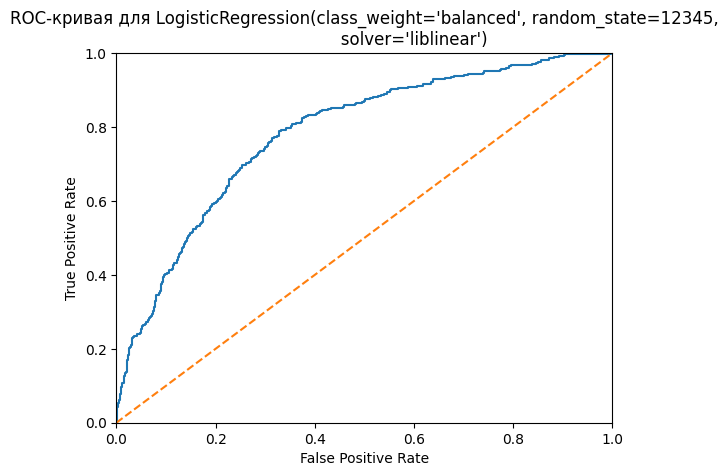

AUC-ROC для LogisticRegression(class_weight='balanced', random_state=12345,
                   solver='liblinear'), 0.7817621121435836


In [36]:
auc_roc_curve_plus_score(lr_model_balanced)

Значение AUC-ROC меняется незначительно по сравнению с моделями без указания аргумента `class_weight='balanced'`

*Подбор гиперпараметров*

**NB!** Не уверена, что в данном случае можно менять `solver`, поэтому к результату ниже отношусь с осторожностью

In [37]:
best_lr_model_balanced = None
best_f1_lr_balanced = 0
for it in range(100, 10000, 100):
    for solver in ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']:
        model = LogisticRegression(random_state=12345, class_weight='balanced', max_iter=it, solver=solver)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)  
        if f1 > best_f1_lr_balanced:
            best_lr_model_balanced = model
            best_f1_lr_balanced = f1
            best_max_iter = it
            best_solver = solver       
                   
        
print("F1 лучшей модели на валидационной выборке:", best_f1_lr_balanced)
print("max_iter наилучшей модели:", best_max_iter)
print("solver наилучшей модели:", solver)      

F1 лучшей модели на валидационной выборке: 0.6102819237147595
max_iter наилучшей модели: 100
solver наилучшей модели: saga


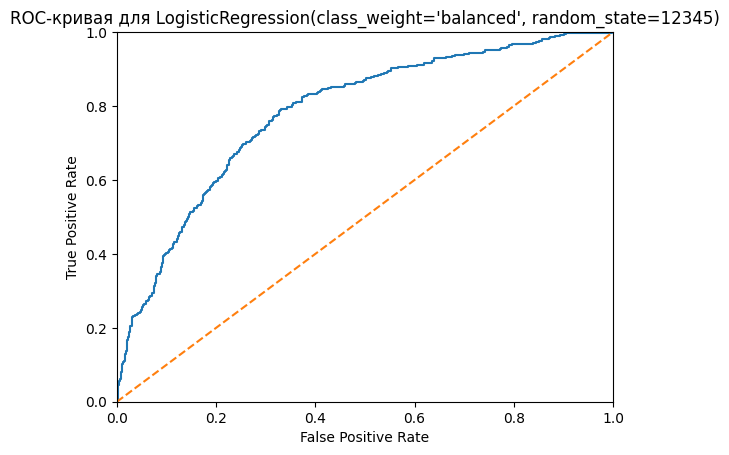

AUC-ROC для LogisticRegression(class_weight='balanced', random_state=12345), 0.7817504677177702


In [38]:
auc_roc_curve_plus_score(best_lr_model_balanced)

При изменении гиперпараметров удается достичь значения F1-меры ниже требуемого порога 0.59, значение AUC-ROC не меняется.

**Выводы:**

При применении техники взвешивания значение `F1-меры` наиболее значительно увеличивается для модели логистической регрессии. При этом во всех случаях оно оказывается ниже требуемого порогового значения 0.59.

Подбор гиперпараметров позволяет увеличить значение `F1-меры` для случайного леса и логистической регрессии до требуемого порогового значения 0.59.


### Увеличение выборки (upsampling)

Порядок преобразования при увеличении выборки:
* Разделить обучающую выборку на отрицательные и положительные объекты;
* Скопировать несколько раз положительные объекты;
* С учётом полученных данных создать новую обучающую выборку;
* Перемешать данные.

Напишем функцию `upsample()` с тремя параметрами:
* `features` — признаки,
* `target` — целевой признак,
* `repeat` — количество повторений.

(8832, 11)
(8832,)


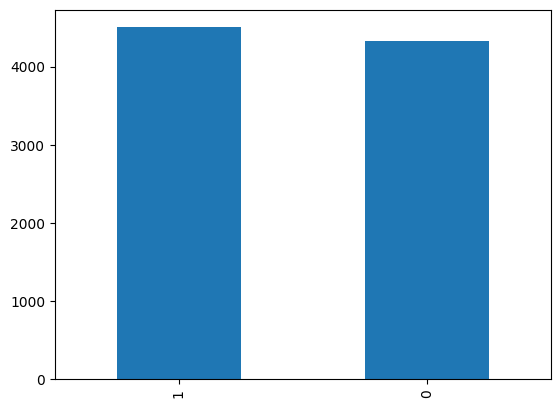

In [39]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat) 
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

# Исходное соотношение классов 1:4, возьмем количество повторений 4
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

# Выведем на экран размеры таблиц
print(features_upsampled.shape)
print(target_upsampled.shape)

# Проверим соотношение классов после увеличения выборки
target_upsampled.value_counts().plot(kind='bar');

Теперь обучим модели.

#### Дерево решений

In [40]:
dt_model = DecisionTreeClassifier(random_state=12345)
dt_model_upsampled = dt_model.fit(features_upsampled, target_upsampled)
dt_predicted_valid_upsampled = dt_model_upsampled.predict(features_valid)

print("F1:", f1_score(target_valid, dt_predicted_valid_upsampled))

F1: 0.46896551724137925


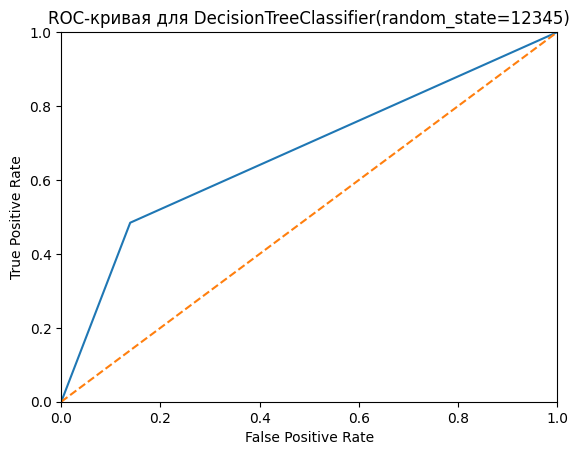

AUC-ROC для DecisionTreeClassifier(random_state=12345), 0.6726829533369044


In [41]:
auc_roc_curve_plus_score(dt_model_upsampled)

*Подбор гиперпараметров*

In [42]:
best_dt_model_upsampled = None
best_f1_dt_upsampled = 0
for criterion in ['entropy', 'gini']:
    for depth in range(1,11):
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth, criterion=criterion)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1_dt_upsampled:
            best_dt_model_upsampled = model
            best_f1_dt_upsampled = f1
            best_depth = depth
            best_criterion = criterion
            

print('F1 лучшей модели:', best_f1_dt_upsampled)
print('max_depth:', best_depth)
print('criterion:', best_criterion)

F1 лучшей модели: 0.5653631284916201
max_depth: 5
criterion: gini


Точно такой же результат, что и для взвешивания классов

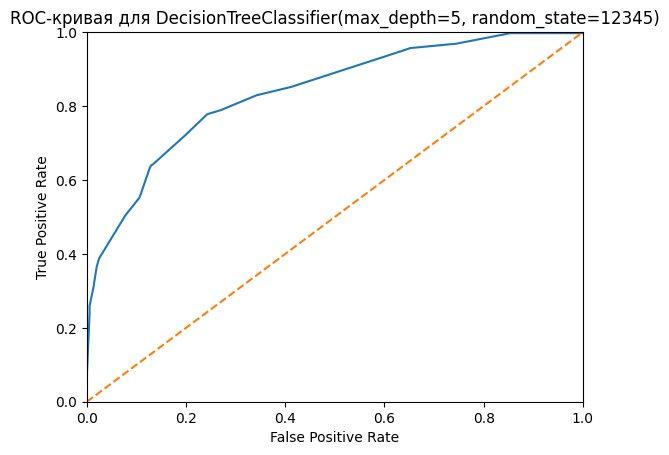

AUC-ROC для DecisionTreeClassifier(max_depth=5, random_state=12345), 0.8374962155616106


In [43]:
auc_roc_curve_plus_score(best_dt_model_upsampled)

#### Случайный лес

In [44]:
# rf_model = RandomForestClassifier(random_state=12345)
rf_model_upsampled = rf_model.fit(features_upsampled, target_upsampled)
rf_predicted_valid_upsampled = rf_model_upsampled.predict(features_valid)

print("F1:", f1_score(target_valid, rf_predicted_valid_upsampled))

F1: 0.6123076923076923


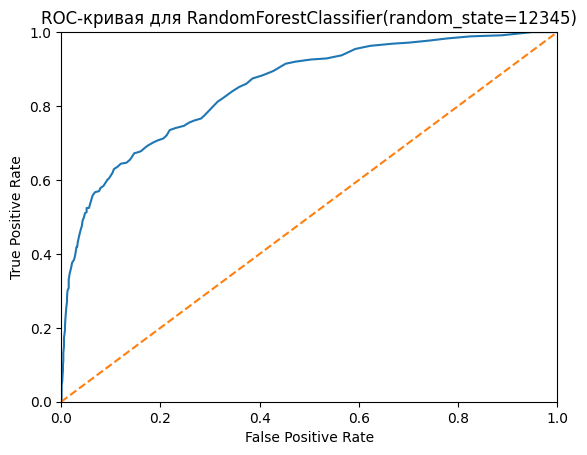

AUC-ROC для RandomForestClassifier(random_state=12345), 0.8498101958592422


In [45]:
auc_roc_curve_plus_score(rf_model_upsampled)

*Подбор гиперпараметров*

In [46]:
best_rf_model_upsampled = None
best_f1_rf_upsampled = 0
for est in range(1, 51): 
    for depth in range(1, 15):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1_rf_upsampled:
            best_rf_model_upsampled = model
            best_f1_rf_upsampled = f1
            best_est = est
            best_depth = depth
        
print("F1 лучшей модели на валидационной выборке:", best_f1_rf_upsampled)
print("Число деревьев в наилучшей модели:", best_est)
print("max_depth наилучшей модели:", best_depth)

F1 лучшей модели на валидационной выборке: 0.6145092460881935
Число деревьев в наилучшей модели: 41
max_depth наилучшей модели: 14


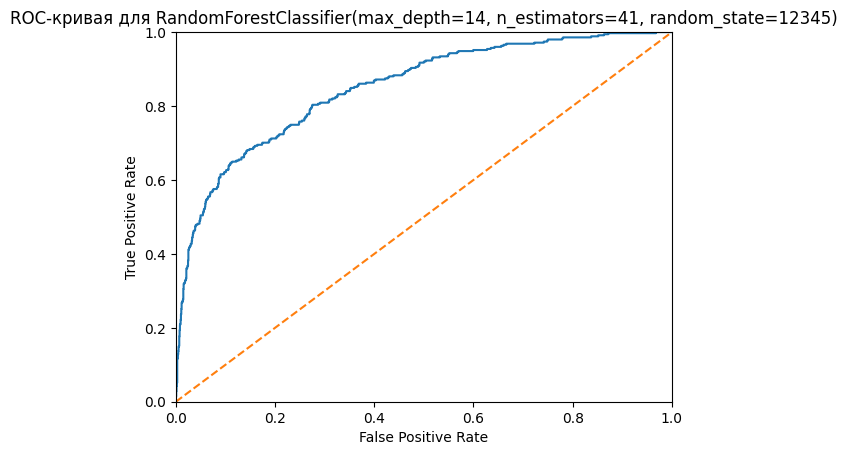

AUC-ROC для RandomForestClassifier(max_depth=14, n_estimators=41, random_state=12345), 0.8492279745685739


In [47]:
auc_roc_curve_plus_score(best_rf_model_upsampled)

При подборе гиперпараметров удается несколько увеличить значение `F-меры` для случайного леса при увеличении выборки.

####  Логистическая регрессия

In [48]:
# lr_model = LogisticRegression(random_state=12345, solver='liblinear')
lr_model_upsampled = lr_model.fit(features_upsampled, target_upsampled)
lr_predicted_valid_upsampled = lr_model_upsampled.predict(features_valid)


print("F1:", f1_score(target_valid, lr_predicted_valid_upsampled))

F1: 0.49653808110781406


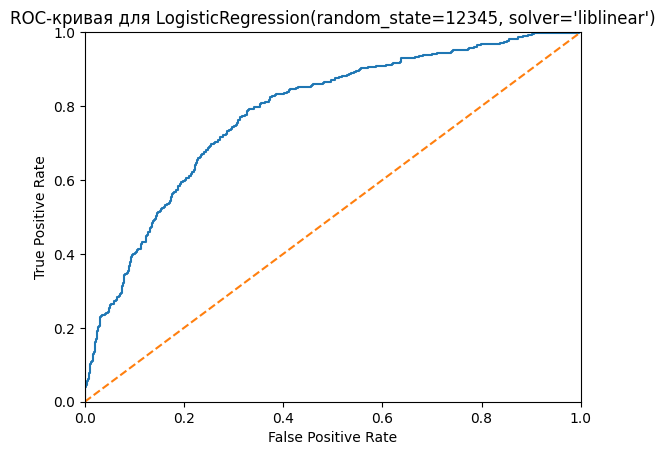

AUC-ROC для LogisticRegression(random_state=12345, solver='liblinear'), 0.7817349418166857


In [49]:
auc_roc_curve_plus_score(lr_model_upsampled)

*Подбор гиперпараметров*

In [50]:
best_lr_model_upsampled = None
best_f1_lr_upsampled = 0
for it in range(100, 10000, 100):
    for solver in ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']:
        model = LogisticRegression(random_state=12345, max_iter=it, solver=solver)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)  
        if f1 > best_f1_lr_upsampled:
            best_lr_model_upsampled = model
            best_f1_lr_upsampled = f1
            best_max_iter = it
            best_solver = solver       
                   
        
print("F1 лучшей модели на валидационной выборке:", best_f1_lr_upsampled)
print("max_iter наилучшей модели:", best_max_iter)
print("solver наилучшей модели:", solver)

F1 лучшей модели на валидационной выборке: 0.603988603988604
max_iter наилучшей модели: 100
solver наилучшей модели: saga


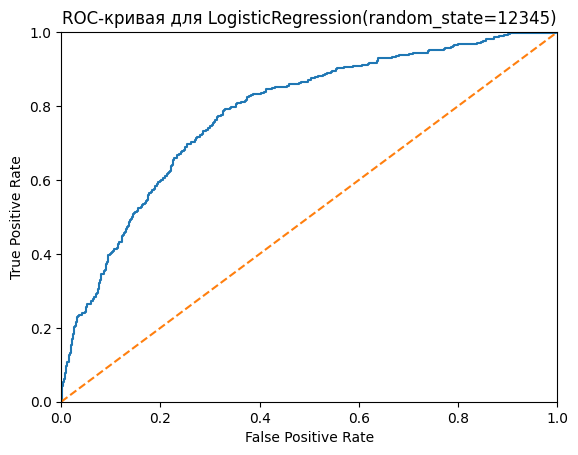

AUC-ROC для LogisticRegression(random_state=12345), 0.7817194159156011


In [51]:
auc_roc_curve_plus_score(best_lr_model_upsampled)

**Выводы:**

При применении техники увеличения выборки значение `F1-меры` случайного леса достигает требуемого значения: оказывается выше 0.59.

При подборе параметров удается несколько улучшить результат для случайного леса. Для логистической регрессии значение `F1-меры` также превышает пороговое значение 0.59.

### Уменьшение выборки (downsampling)

Порядок преобразования при уменьшении выборки:
* Разделить обучающую выборку на отрицательные и положительные объекты;
* Случайным образом отбросить часть из отрицательных объектов;
* С учётом полученных данных создать новую обучающую выборку;
* Перемешать данные. 

Напишем функцию `downsample()` с тремя параметрами:
* `features` — признаки,
* `target` — целевой признак,
* `fraction` — доля отрицательных объектов, которые нужно сохранить.

(2208, 11)
(2208,)


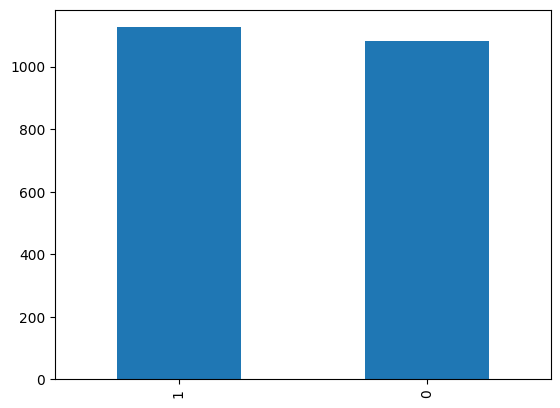

In [52]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled
                                                                      

# Исходное соотношение классов 1:4, возьмем долю 0.25
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

# Выведем на экран размеры таблиц
print(features_downsampled.shape)
print(target_downsampled.shape)

# Проверим соотношение классов после уменьшения выборки
target_downsampled.value_counts().plot(kind='bar');

Теперь обучим модели.

#### Дерево решений

In [53]:
# dt_model = DecisionTreeClassifier(random_state=12345)
dt_model_downsampled = dt_model.fit(features_downsampled, target_downsampled)
dt_predicted_valid_downsampled = dt_model_downsampled.predict(features_valid)

print("F1:", f1_score(target_valid, dt_predicted_valid_downsampled))

F1: 0.5037735849056603


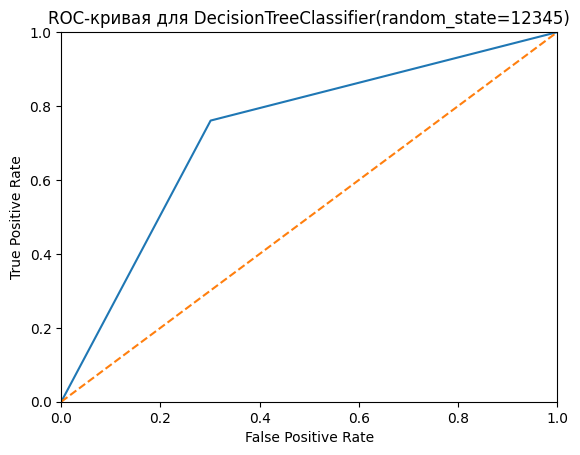

AUC-ROC для DecisionTreeClassifier(random_state=12345), 0.7297969212138149


In [54]:
auc_roc_curve_plus_score(dt_model_downsampled)

*Подбор гиперпараметров*

In [55]:
best_dt_model_downsampled = None
best_f1_dt_downsampled = 0
for criterion in ['entropy', 'gini']:
    for depth in range(1,11):
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth, criterion=criterion)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1_dt_downsampled:
            best_dt_model_downsampled = model
            best_f1_dt_downsampled = f1
            best_depth = depth
            best_criterion = criterion
            

print('F1 лучшей модели:', best_f1_dt_downsampled)
print('max_depth:', best_depth)
print('criterion:', best_criterion)

F1 лучшей модели: 0.5485148514851486
max_depth: 6
criterion: gini


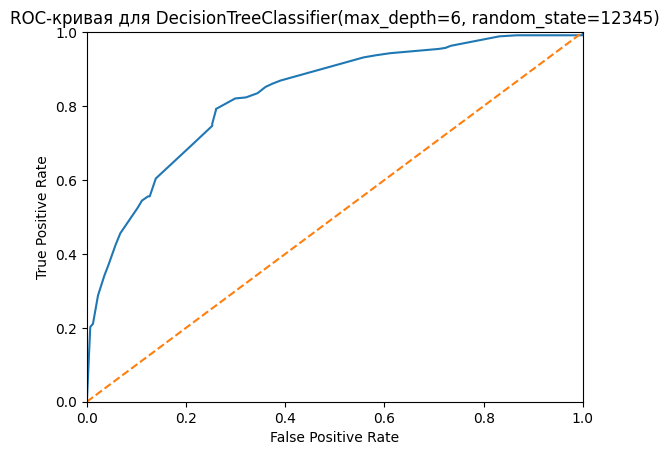

AUC-ROC для DecisionTreeClassifier(max_depth=6, random_state=12345), 0.8290210143071178


In [56]:
auc_roc_curve_plus_score(best_dt_model_downsampled)

Результаты несколько хуже, чем для взвешивания классов и увеличения выборки

#### Случайный лес

In [57]:
# rf_model = RandomForestClassifier(random_state=12345)
rf_model_downsampled = rf_model.fit(features_downsampled, target_downsampled)
rf_predicted_valid_downsampled = rf_model_downsampled.predict(features_valid)

print("F1:", f1_score(target_valid, rf_predicted_valid_downsampled))

F1: 0.5607287449392714


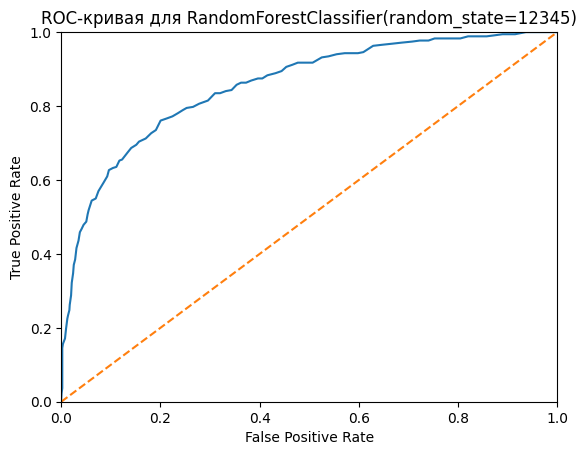

AUC-ROC для RandomForestClassifier(random_state=12345), 0.8548687285063307


In [58]:
auc_roc_curve_plus_score(rf_model_downsampled)

*Подбор гиперпараметров*

In [59]:
best_rf_model_downsampled = None
best_f1_rf_downsampled = 0
for est in range(1, 51): 
    for depth in range(1, 15):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1_rf_downsampled:
            best_rf_model_downsampled = model
            best_f1_rf_downsampled = f1
            best_est = est
            best_depth = depth
        
print("F1 лучшей модели на валидационной выборке:", best_f1_rf_downsampled)
print("Число деревьев в наилучшей модели:", best_est)
print("max_depth наилучшей модели:", best_depth)

F1 лучшей модели на валидационной выборке: 0.5834254143646409
Число деревьев в наилучшей модели: 10
max_depth наилучшей модели: 5


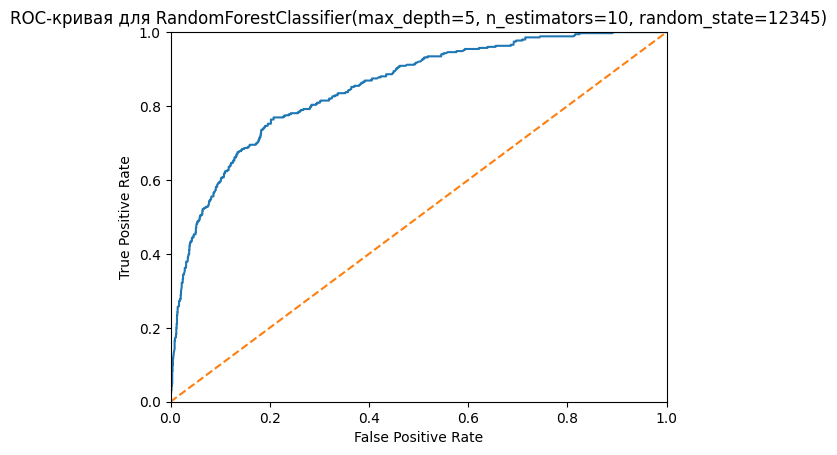

AUC-ROC для RandomForestClassifier(max_depth=5, n_estimators=10, random_state=12345), 0.8497102478710108


In [60]:
auc_roc_curve_plus_score(best_rf_model_downsampled)

Значение `F1-меры` не достигает необходимого порога 0.59. Значение `AUC-ROC` при подборе гиперпараметров меняется незначительно.

####  Логистическая регрессия

In [61]:
# lr_model = LogisticRegression(random_state=12345, solver='liblinear')
lr_model_downsampled = lr_model.fit(features_downsampled, target_downsampled)
lr_predicted_valid_downsampled = lr_model_downsampled.predict(features_valid)

print("F1:", f1_score(target_valid, lr_predicted_valid_downsampled))

F1: 0.4911591355599214


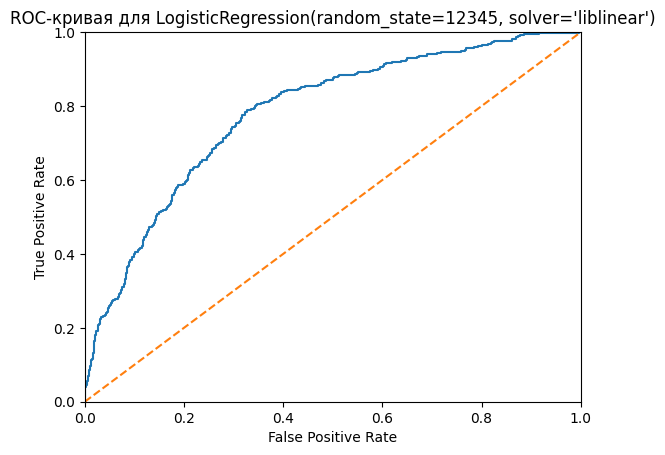

AUC-ROC для LogisticRegression(random_state=12345, solver='liblinear'), 0.7806655953794919


In [62]:
auc_roc_curve_plus_score(lr_model_downsampled)

*Подбор гиперпараметров*

In [63]:
best_lr_model_downsampled = None
best_f1_lr_downsampled = 0
for it in range(100, 10000, 100):
    for solver in ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']:
        model = LogisticRegression(random_state=12345, max_iter=it, solver=solver)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)  
        if f1 > best_f1_lr_downsampled:
            best_lr_model_downsampled = model
            best_f1_lr_downsampled = f1
            best_max_iter = it
            best_solver = solver       
                   
        
print("F1 лучшей модели на валидационной выборке:", best_f1_lr_downsampled)
print("max_iter наилучшей модели:", best_max_iter)
print("solver наилучшей модели:", solver)

F1 лучшей модели на валидационной выборке: 0.5532786885245902
max_iter наилучшей модели: 100
solver наилучшей модели: saga


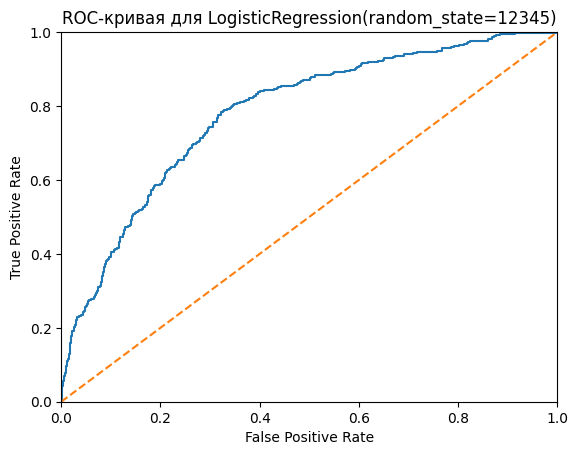

AUC-ROC для LogisticRegression(random_state=12345), 0.7807199360332875


In [64]:
auc_roc_curve_plus_score(best_lr_model_downsampled)

**Выводы:**

При применении техники уменьшения выборки ни для одной модели `F1-мера` не достигает значения 0.59.

При подборе гиперпараметров не приводит `F1-мера` также не достигает требуемого порога.

Значения AUC-ROC не сильно различаются по сравнению с моделями, обученными до уменьшения выборки.

### Выводы по разделу 3

* Были рассмотрены три техники борьбы с дисбалансом: взвешивание классов, увеличение выборки и уменьшение выборки.
* F1-мера 
    * для дерева решений меняется незначительно при применении техник борьбы с дисбалансом, увеличивается при подборе гиперпараметров
    * для случайного леса в целом показывает лучшие результаты по сравнению с другими моделями, при подборе гиперпараметров больше всего возрастает в случае взвешивания классов
    * для логистической регрессии значительно возрастает при применении всех техник борьбы с дисбалансом, возрастает при подборе гиперпараметров
    * выше всего для случайного леса при применении техники взвешивания классов с подбором гиперпараметров (F1=0.6226; n_estimators=15, max_depth=11), несколько ниже, но также удовлетворяет условиям задачи при применении техники увеличения выборки без подбора (0.6123) и с подбором (0.6145; n_estimators=41, max_depth=14) гиперпараметров.
* AUC-ROC
    * меняется незначительно при применении техник борьбы с дисбалансом
    * для дерева решений значительно увеличивается при подборе гиперпараметров
    * для случайного леса меняется незначительно при подборе гиперпараметров
    * для логистической регрессии практически не меняется
    

## Тестирование модели

1. Проверим качество лучшей модели на тестовой выборке. По результатам приведенноно выше рассмотрения лучшее значение `F1-меры` показывает модель случайного леса при применении техники взвешивания классов со значениями гиперпараметров `n_estimators=15`, `max_depth=11`.

In [65]:
best_rf_model_balanced

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=25,
                       random_state=12345)

In [66]:
best_rf_model_balanced.fit(features_train, target_train)
rf_predicted_test_balanced = rf_model_balanced.predict(features_test)
print("F1:", f1_score(target_test, rf_predicted_test_balanced))

F1: 0.5757575757575758


Значение `F1-меры` ниже 0.59.

2. Второе лучшее значение `F1-меры` показывает модель случайного леса при применении техники увеличения выборки классов с со значениями гиперпараметров `n_estimators=41`, `max_depth=14`

In [67]:
best_rf_model_upsampled

RandomForestClassifier(max_depth=14, n_estimators=41, random_state=12345)

In [68]:
best_rf_model_upsampled.fit(features_upsampled, target_upsampled)
rf_predicted_test_upsampled = best_rf_model_upsampled.predict(features_test)
print("F1:", f1_score(target_test, rf_predicted_test_upsampled))

F1: 0.6253369272237197


Значение `F1-меры` выше  0.59. Модель прошла проверку на тестовой выборке

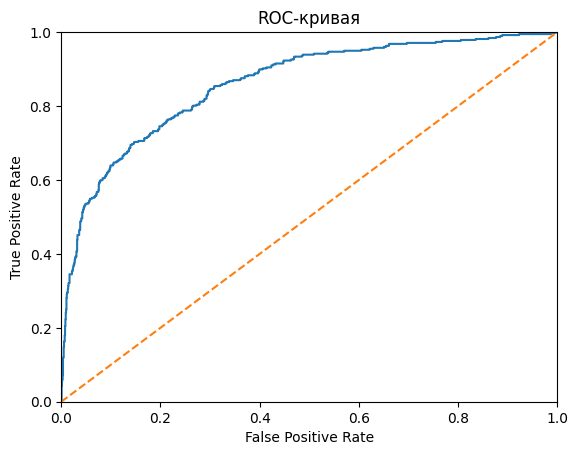

Значение AUC-ROC на тестовой выборке: 0.8595011200960134


In [69]:
probabilities_one_test = best_rf_model_upsampled.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('Значение AUC-ROC на тестовой выборке:', auc_roc)

## Итоги

На основании данных о поведении клиентов "Бета-Банка", была построена модель с максимально возможным значением `F1-меры`, которая предсказывает уход клиентов из банка. В ходе работы были выполнены следующие действия:

* данные загружены и подготовлены, устранены пропуски
* исследован баланса классов, модели обучены без учёта дисбаланса.
* качество модели улучшено с учетом дисбаланса классов: обучены разные модели и выбраны лучшие (в том числе подобраны гиперпараметры).
* проведена проверка на тестовой выборке.

**Общий вывод**: 
Наилучший результат показывала модель случайного леса, обученная с применением техники увеличения выборки, с гиперпараметрами `max_depth`=14, `n_estimators`=41, которая показывает на тестовой выборке  значение `F1-меры`  около 0.6173.